In [1]:
# Import libraries and setup the environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

print("Iris dataset loaded with {} samples and {} features.".format(X.shape[0], X.shape[1]))


Iris dataset loaded with 150 samples and 4 features.


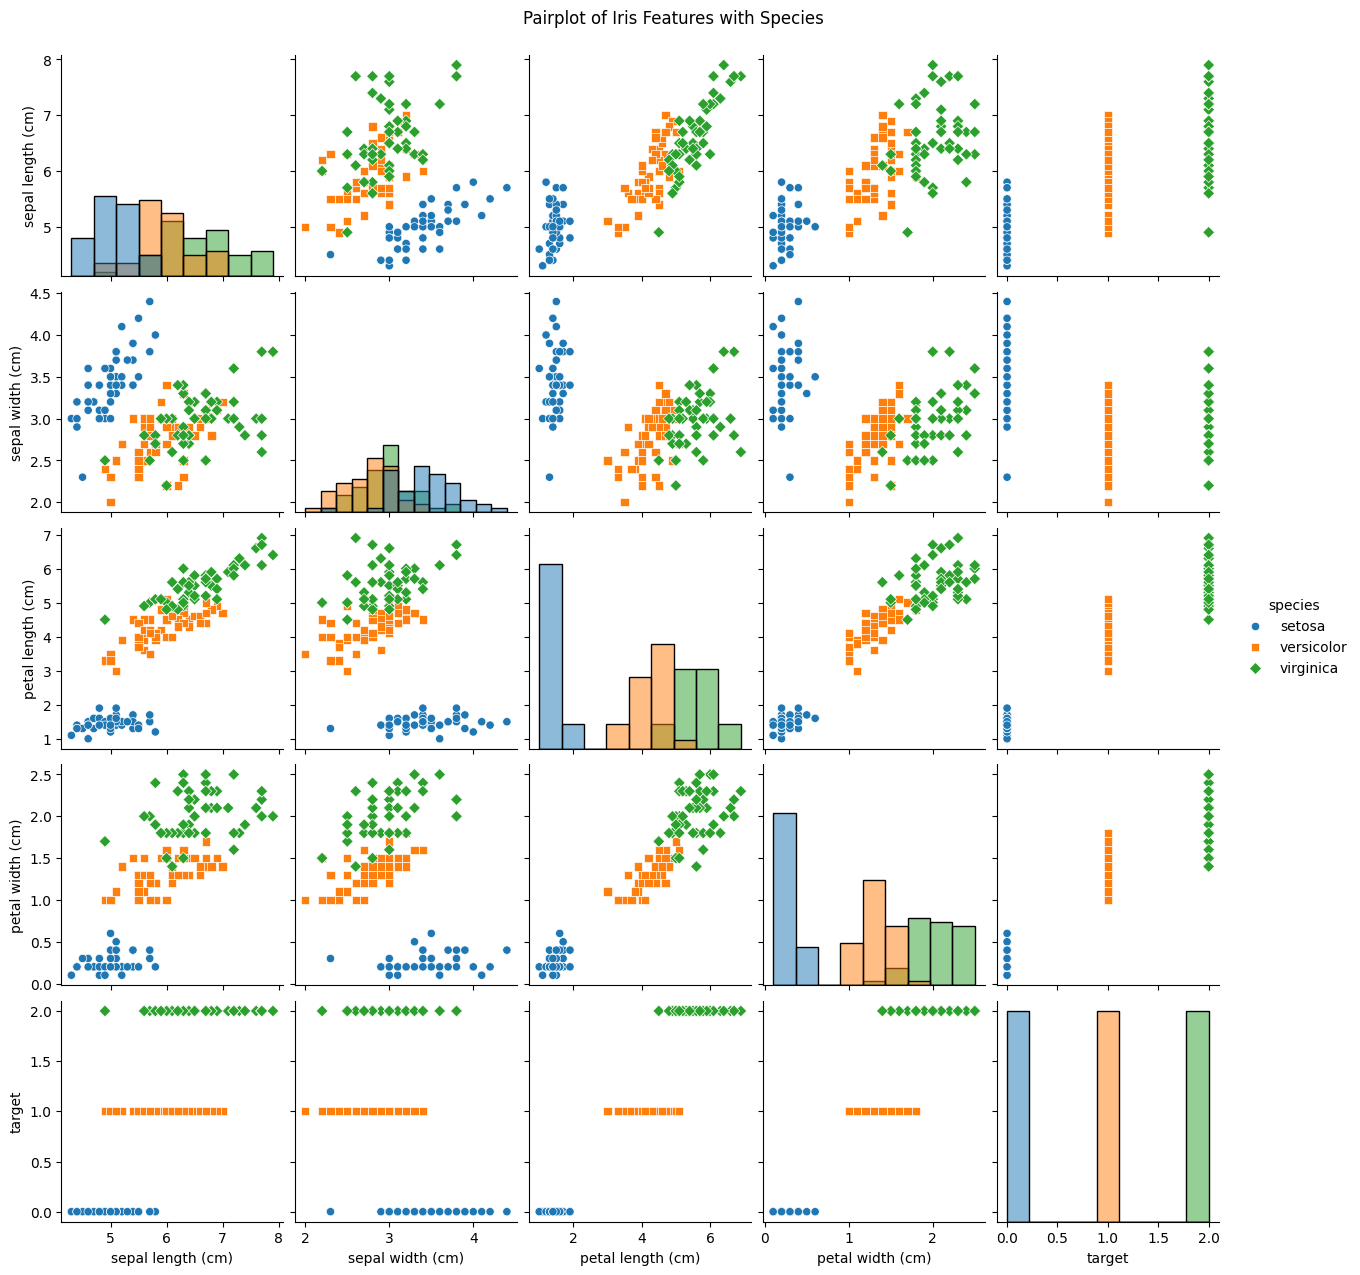

In [2]:
# Create a DataFrame for visualization purposes
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['species'] = df['target'].apply(lambda i: class_names[i])

# Plot pairplot to visualize feature relationships and class overlap
sns.pairplot(df, hue='species', diag_kind='hist', markers=["o", "s", "D"])
plt.suptitle("Pairplot of Iris Features with Species", y=1.02)
plt.show()


In [3]:
# Split dataset into training and testing sets (80/20 split) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features to improve SVM performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a baseline SVM model with probability estimates enabled
svm_clf = SVC(probability=True, kernel='rbf', random_state=42)
svm_clf.fit(X_train_scaled, y_train)

# Predict on the test set and evaluate the baseline model
y_pred_proba = svm_clf.predict_proba(X_test_scaled)
y_pred = svm_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Baseline SVM Model Accuracy (No Noise): {:.2f}%".format(accuracy * 100))


Baseline SVM Model Accuracy (No Noise): 96.67%


In [4]:
# Define two noise levels: low (0.05) and high (0.2)
noise_levels = [0.05, 0.2]
results = {}

for noise in noise_levels:
    # Ensure reproducibility by setting a seed
    np.random.seed(42)
    # Add Gaussian noise to the training and testing data
    X_train_noisy = X_train_scaled + np.random.normal(0, noise, X_train_scaled.shape)
    X_test_noisy = X_test_scaled + np.random.normal(0, noise, X_test_scaled.shape)

    # Train an SVM model on the noisy data
    svm_noisy = SVC(probability=True, kernel='rbf', random_state=42)
    svm_noisy.fit(X_train_noisy, y_train)

    # Evaluate the model on the noisy test data
    y_pred_noisy = svm_noisy.predict(X_test_noisy)
    acc_noisy = accuracy_score(y_test, y_pred_noisy)

    # Store the model and its results
    results[noise] = {'model': svm_noisy, 'accuracy': acc_noisy, 'X_test_noisy': X_test_noisy}
    print("SVM Model Accuracy with Noise Level {}: {:.2f}%".format(noise, acc_noisy * 100))


SVM Model Accuracy with Noise Level 0.05: 93.33%
SVM Model Accuracy with Noise Level 0.2: 90.00%


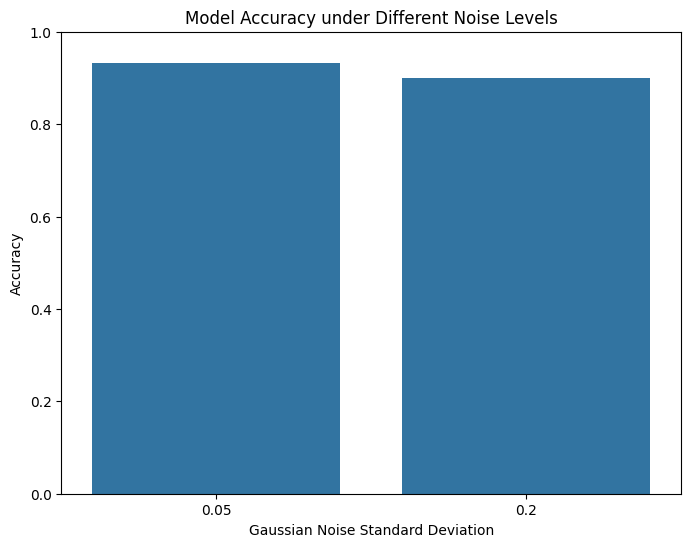

In [5]:
# Visualize the impact of different noise levels on accuracy
noise_levels_str = [str(n) for n in noise_levels]
accuracies = [results[n]['accuracy'] for n in noise_levels]

plt.figure(figsize=(8, 6))
sns.barplot(x=noise_levels_str, y=accuracies)
plt.xlabel("Gaussian Noise Standard Deviation")
plt.ylabel("Accuracy")
plt.title("Model Accuracy under Different Noise Levels")
plt.ylim(0, 1)
plt.show()


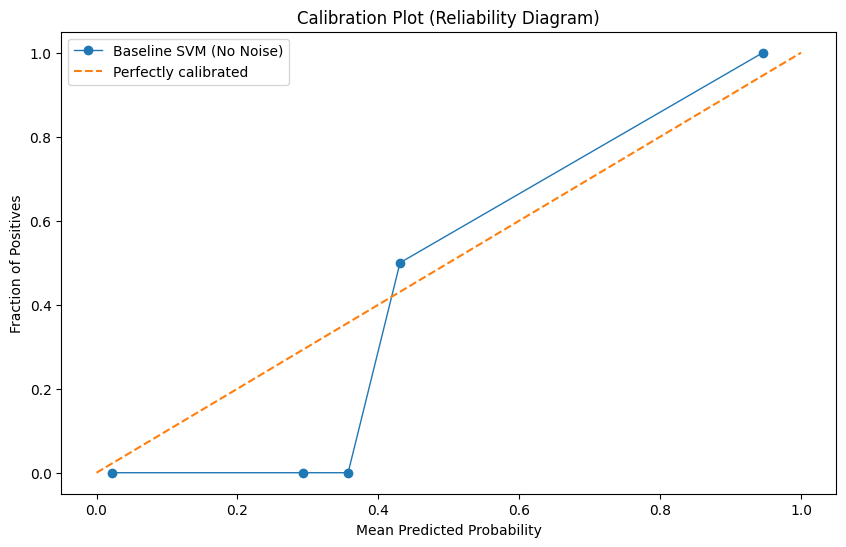

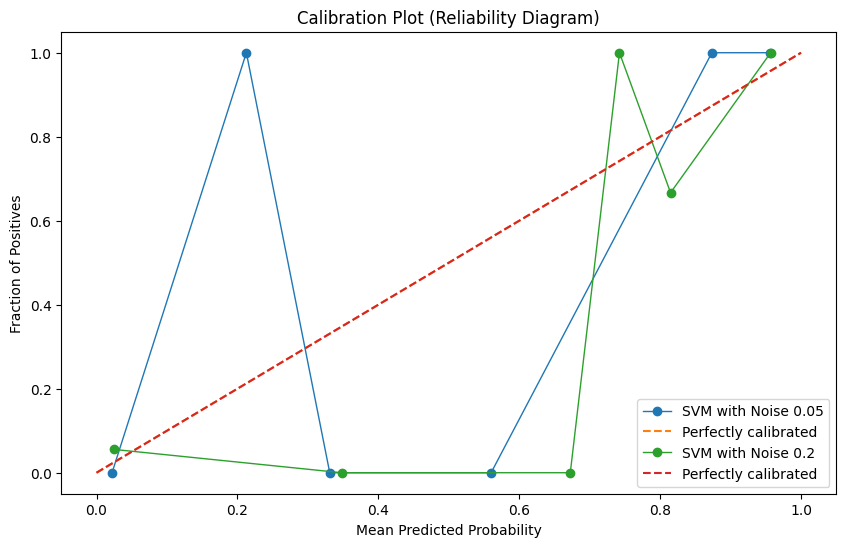

In [6]:
# Define a helper function to plot the calibration curve
def plot_calibration_curve(model, X, y, model_name="Model"):
    # For binary calibration, we extract probabilities for class 1 (one-vs-rest)
    prob_true, prob_pred = calibration_curve(y, model.predict_proba(X)[:, 1], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly calibrated")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Plot (Reliability Diagram)")
    plt.legend()

# Calibration plot for the baseline SVM (no noise)
plt.figure(figsize=(10, 6))
plot_calibration_curve(svm_clf, X_test_scaled, (y_test==1).astype(int), model_name="Baseline SVM (No Noise)")
plt.show()

# Calibration plots for the noisy models
plt.figure(figsize=(10, 6))
for noise in noise_levels:
    model = results[noise]['model']
    X_test_noisy = results[noise]['X_test_noisy']
    plot_calibration_curve(model, X_test_noisy, (y_test==1).astype(int), model_name=f"SVM with Noise {noise}")
plt.show()


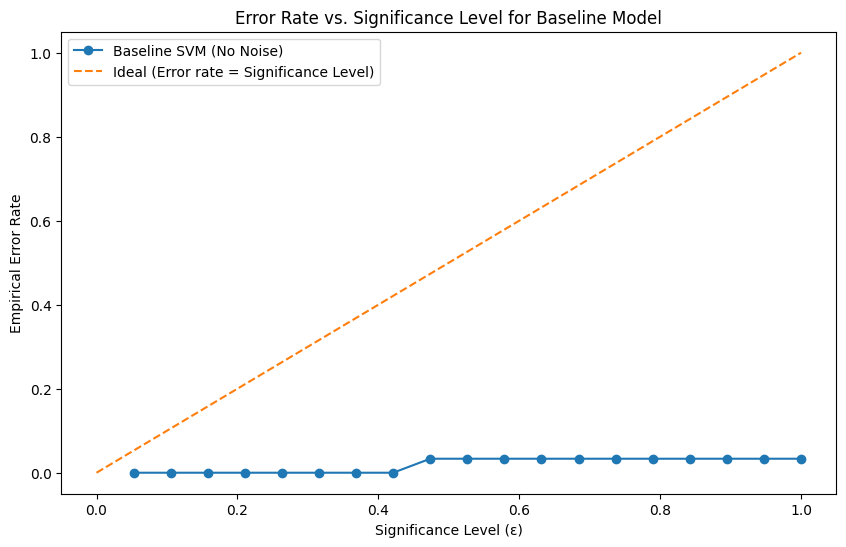

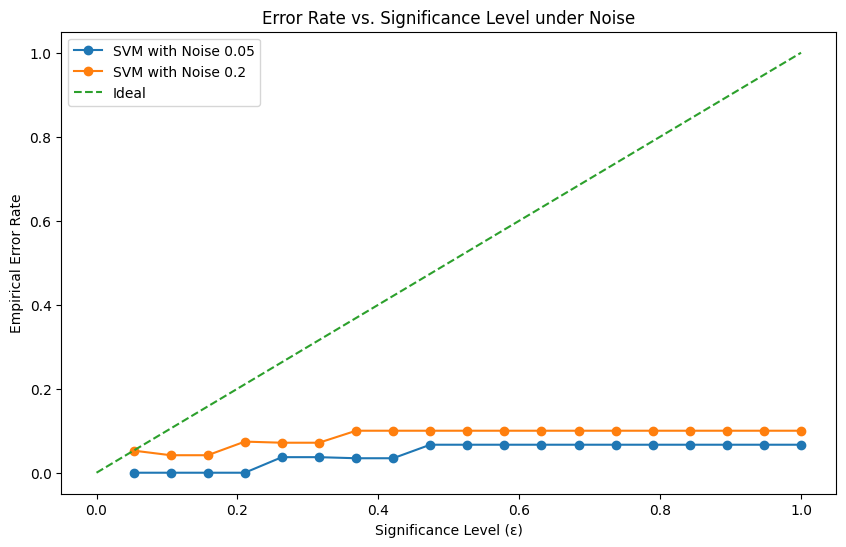

In [7]:
# Function to compute empirical error rate versus significance level
def error_rate_vs_significance(model, X, y, epsilon_values):
    # Compute predicted probabilities and corresponding confidences
    proba = model.predict_proba(X)
    confidences = np.max(proba, axis=1)
    uncertainties = 1 - confidences  # Higher uncertainty when confidence is low
    empirical_error_rates = []
    for eps in epsilon_values:
        # Select samples with uncertainty less than or equal to eps
        indices = uncertainties <= eps
        if np.sum(indices) > 0:
            y_pred = model.predict(X)
            error_rate = np.mean(y_pred[indices] != y[indices])
        else:
            error_rate = np.nan
        empirical_error_rates.append(error_rate)
    return empirical_error_rates

# Define a range of significance levels
epsilon_values = np.linspace(0, 1, 20)

# Compute and plot error rate vs. significance level for the baseline model
baseline_errors = error_rate_vs_significance(svm_clf, X_test_scaled, y_test, epsilon_values)

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, baseline_errors, marker='o', label='Baseline SVM (No Noise)')
plt.plot(epsilon_values, epsilon_values, linestyle='--', label='Ideal (Error rate = Significance Level)')
plt.xlabel("Significance Level (ε)")
plt.ylabel("Empirical Error Rate")
plt.title("Error Rate vs. Significance Level for Baseline Model")
plt.legend()
plt.show()

# Compute and plot error rate vs. significance level for the noisy models
plt.figure(figsize=(10, 6))
for noise in noise_levels:
    model = results[noise]['model']
    X_test_noisy = results[noise]['X_test_noisy']
    errors = error_rate_vs_significance(model, X_test_noisy, y_test, epsilon_values)
    plt.plot(epsilon_values, errors, marker='o', label=f"SVM with Noise {noise}")
plt.plot(epsilon_values, epsilon_values, linestyle='--', label='Ideal')
plt.xlabel("Significance Level (ε)")
plt.ylabel("Empirical Error Rate")
plt.title("Error Rate vs. Significance Level under Noise")
plt.legend()
plt.show()


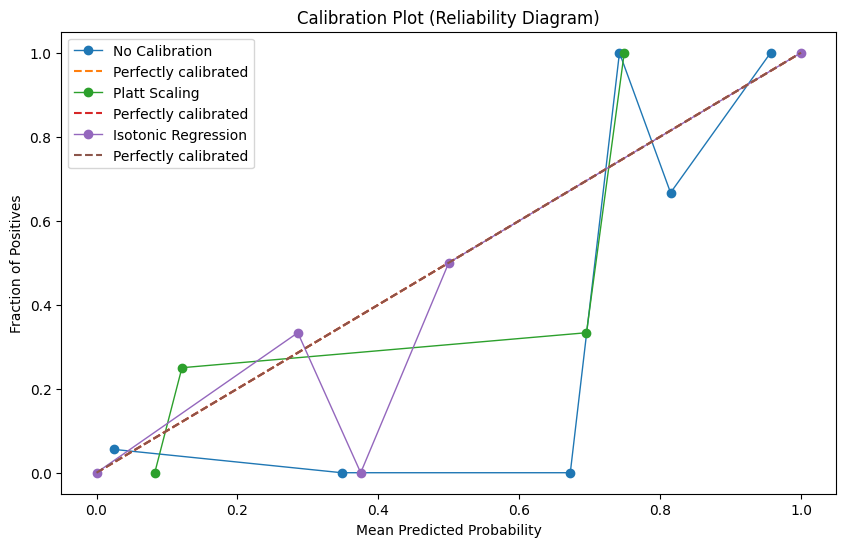

No Calibration - Accuracy: 0.90, Brier Score Loss (for class 1): 0.0768
Platt Scaling - Accuracy: 0.90, Brier Score Loss (for class 1): 0.0842
Isotonic Regression - Accuracy: 0.93, Brier Score Loss (for class 1): 0.0438


In [8]:
# Select the model trained with high noise (σ = 0.2) for calibration
noise_level = 0.2
model_noisy = results[noise_level]['model']
# For calibration, we generate a new noisy training set (for demonstration purposes)
X_train_noisy = X_train_scaled + np.random.normal(0, noise_level, X_train_scaled.shape)
X_test_noisy = results[noise_level]['X_test_noisy']

# Apply Platt Scaling (sigmoid method)
platt_calibrated = CalibratedClassifierCV(model_noisy, cv='prefit', method='sigmoid')
platt_calibrated.fit(X_test_noisy, y_test)  # For demonstration, we use the test set for calibration

# Apply Isotonic Regression
isotonic_calibrated = CalibratedClassifierCV(model_noisy, cv='prefit', method='isotonic')
isotonic_calibrated.fit(X_test_noisy, y_test)

# Plot calibration curves for the original (uncalibrated) and calibrated models
plt.figure(figsize=(10, 6))
plot_calibration_curve(model_noisy, X_test_noisy, (y_test==1).astype(int), model_name="No Calibration")
plot_calibration_curve(platt_calibrated, X_test_noisy, (y_test==1).astype(int), model_name="Platt Scaling")
plot_calibration_curve(isotonic_calibrated, X_test_noisy, (y_test==1).astype(int), model_name="Isotonic Regression")
plt.show()

# Define a helper function to evaluate models
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    # Compute Brier score loss for class 1 (binary perspective)
    brier = brier_score_loss((y==1).astype(int), model.predict_proba(X)[:,1])
    return acc, brier

# Evaluate the original and calibrated models
models = {"No Calibration": model_noisy, "Platt Scaling": platt_calibrated, "Isotonic Regression": isotonic_calibrated}
for name, mdl in models.items():
    acc, brier = evaluate_model(mdl, X_test_noisy, y_test)
    print(f"{name} - Accuracy: {acc:.2f}, Brier Score Loss (for class 1): {brier:.4f}")
